In [1]:
import os
import re

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from PIL import Image

warnings.filterwarnings(action='ignore')

<br/>

# 데이터 분석을 위한 준비 과정

## 기존 데이터 분석
#### 기존에 주어진 train data가 어떤지 살펴봅니다.

In [3]:
# 새로 변환한 파일 저장 위치와 파일명
TrainFile = './train/train.csv'
NewTrainFile = './train/new_train.csv'

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 2000)

In [4]:
train = pd.read_csv(TrainFile)
train.head(50)

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59
5,000007,female,Asian,58,000007_female_Asian_58
6,000008,female,Asian,58,000008_female_Asian_58
7,000009,female,Asian,56,000009_female_Asian_56
8,000010,female,Asian,58,000010_female_Asian_58
9,000012,male,Asian,57,000012_male_Asian_57


#### 기존의 데이터에는 마스크 착용 여부에 대한 분류가 제대로 되어 있지 않으므로 레이블 컬럼을 추가하여 이를 전처리할 필요가 있습니다.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2700 non-null   object
 1   gender  2700 non-null   object
 2   race    2700 non-null   object
 3   age     2700 non-null   int64 
 4   path    2700 non-null   object
dtypes: int64(1), object(4)
memory usage: 105.6+ KB


<br/>

## EDA를 위한 데이터 전처리
#### EDA를 진행하기에 효율적으로 데이터를 가공합니다.
---
#### 나이대, 성별, 마스크 착용 상태를 바탕으로 총 18개의 레이블로 분류해야 합니다.
- 나이대
    - 30대 미만 = 0
    - 30대 이상 60대 미만 = 1
    - 60대 이상 = 2
- 성별
    - 남성 = 0
    - 여성 = 1
- 마스크 착용 상태
    - 마스크 착용 상태(wear) = 0
    - 마스크를 잘못 착용한 상태(incorrect) = 1
    - 마스크를 착용하지 않은 상태(normal) = 2

#### (레이블) = (마스크 착용 상태) * 6 + (성별) * 3 + (나이대)

In [6]:
class Preprocessor:
    
    columnList = ['id', 'gender', 'age', 'age_group', 'directory', 'file', 'masked']
    
    # 이미지 폴더 위치를 지정한다.
    imagesDir = '../input/data/train/images'
    imageExtension = ['.jpg', '.png', '.jpeg']
    
    def __init__(self):
        self.dataFrame = pd.DataFrame(None, columns = Preprocessor.columnList)
    
    def preprocess(self, directory):
        try:
            fileList = os.listdir(directory)
            for file in fileList:
                filePath = os.path.join(directory, file)
                
                if re.match('^[.]', file):
                    continue
                
                # 현재 보고 있는 것이 폴더일 경우
                if os.path.isdir(filePath):
                    self.preprocess(filePath)
                # 현재 보고 있는 것이 파일일 경우
                else:
                    # 파일의 확장자만을 분리하여 저장한다.
                    fileName, fileExtension = os.path.splitext(file)

                    # 파일의 확장자가 이미지인 경우
                    if fileExtension in Preprocessor.imageExtension:
                        
                        data = dict()
                        
                        info = directory.split('/')[-1].split('_')
                        
                        data['id'] = info[0]
                        data['gender'] = 1 if info[1] == 'female' else 0
                        data['age'] = int(info[3])
                        data['directory'] = directory
                        data['file'] = file
                        
                        
                        # 문제에서 주어진 나이대 별로 나눠준다.
                        age = int(data['age'])
                        
                        if age < 30:
                            data['age_group'] = 0
                        elif age >= 30 and age < 60:
                            data['age_group'] = 1
                        else:
                            data['age_group'] = 2
                        
                        
                        if fileName == 'normal':
                            data['masked'] = 2
                        elif fileName == 'incorrect_mask':
                            data['masked'] = 1
                        else:
                            data['masked'] = 0
                            
                        data['label'] = data['masked'] * 6 + data['gender'] * 3 + data['age_group']
                        
                        self.dataFrame = self.dataFrame.append(data, ignore_index = True)
                        self.dataFrame['label'] = self.dataFrame['label'].astype(int)
                        
        except PermissionError:
            pass
        
        self.dataFrame = self.dataFrame.sort_values('id')
        return self.dataFrame

In [7]:
preprocessor = Preprocessor()
dataFrame = preprocessor.preprocess(Preprocessor.imagesDir)

In [8]:
dataFrame.to_csv(NewTrainFile, mode='w', index=False, encoding='utf-8-sig')

In [9]:
train = pd.read_csv(NewTrainFile)
train.head(50)

,id,gender,age,age_group,directory,file,masked,label
0,000001,1,45,1,../input/data/train/images/000001_female_Asian_45,mask3.jpg,0,4
1,000001,1,45,1,../input/data/train/images/000001_female_Asian_45,normal.jpg,2,16
2,000001,1,45,1,../input/data/train/images/000001_female_Asian_45,mask1.jpg,0,4
3,000001,1,45,1,../input/data/train/images/000001_female_Asian_45,mask5.jpg,0,4
4,000001,1,45,1,../input/data/train/images/000001_female_Asian_45,mask4.jpg,0,4
5,000001,1,45,1,../input/data/train/images/000001_female_Asian_45,incorrect_mask.jpg,1,10
6,000001,1,45,1,../input/data/train/images/000001_female_Asian_45,mask2.jpg,0,4
7,000002,1,52,1,../input/data/train/images/000002_female_Asian_52,mask3.jpg,0,4
8,000002,1,52,1,../input/data/train/images/000002_female_Asian_52,mask5.jpg,0,4
9,000002,1,52,1,../input/data/train/images/000002_female_Asian_52,mask1.jpg,0,4


#### 총 18900개의 데이터 행이 존재하며, 결측치는 없는 것으로 확인됩니다.

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18900 entries, 0 to 18899
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         18900 non-null  object
 1   gender     18900 non-null  int64 
 2   age        18900 non-null  int64 
 3   age_group  18900 non-null  int64 
 4   directory  18900 non-null  object
 5   file       18900 non-null  object
 6   masked     18900 non-null  int64 
 7   label      18900 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 1.2+ MB


#### 그래도 결측치가 있는지 확인해 봅시다.

In [11]:
train.isnull().sum()

id           0
gender       0
age          0
age_group    0
directory    0
file         0
masked       0
label        0
dtype: int64

<br/>

# 데이터 시각화 및 분석

## 데이터 시각화 설정
#### 우선 EDA 전에 데이터 시각화를 예쁘게 꾸미기 위한 설정을 해봅시다.

In [12]:
from cycler import cycler

raw_light_palette = [
    (0, 122, 255), # Blue
    (255, 149, 0), # Orange
    (52, 199, 89), # Green
    (255, 59, 48), # Red
    (175, 82, 222),# Purple
    (255, 45, 85), # Pink
    (88, 86, 214), # Indigo
    (90, 200, 250),# Teal
    (255, 204, 0)  # Yellow
]

raw_dark_palette = [
    (10, 132, 255), # Blue
    (255, 159, 10), # Orange
    (48, 209, 88),  # Green
    (255, 69, 58),  # Red
    (191, 90, 242), # Purple
    (94, 92, 230),  # Indigo
    (255, 55, 95),  # Pink
    (100, 210, 255),# Teal
    (255, 214, 10)  # Yellow
]

raw_gray_light_palette = [
    (242, 242, 247),# White
    (174, 174, 178),# White (2)
    (199, 199, 204),# White (3)
    (209, 209, 214),# White (4)
    (229, 229, 234),# White (5)
    (242, 242, 247),# White (6)
]

raw_gray_dark_palette = [
    (142, 142, 147),# Gray
    (99, 99, 102),  # Gray (2)
    (72, 72, 74),   # Gray (3)
    (58, 58, 60),   # Gray (4)
    (44, 44, 46),   # Gray (5)
    (28, 28, 39),   # Gray (6)
]


light_palette = np.array(raw_light_palette)/255
dark_palette = np.array(raw_dark_palette)/255
gray_light_palette = np.array(raw_gray_light_palette)/255
gray_dark_palette = np.array(raw_gray_dark_palette)/255

#### Data Visualization의 7-1강에서 소개했던 color map을 응용해 봤습니다.

In [13]:
# cmap 수정
mpl.rcParams['axes.prop_cycle'] = cycler('color',dark_palette)

# 전체적인 배경색 수정
mpl.rcParams['figure.facecolor']  = gray_light_palette[0]
mpl.rcParams['figure.edgecolor']  = gray_light_palette[0]
mpl.rcParams['axes.facecolor'] =  gray_light_palette[0]

# 사용되는 텍스트 색상 흰색으로 수정
gray_color = gray_dark_palette[-1]
mpl.rcParams['text.color'] = gray_color
mpl.rcParams['axes.labelcolor'] = gray_color
mpl.rcParams['axes.edgecolor'] = gray_color
mpl.rcParams['xtick.color'] = gray_color
mpl.rcParams['ytick.color'] = gray_color

# 해상도 조정
mpl.rcParams['figure.dpi'] = 200

# ax의 우측과 상단 지우기
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

<br/>

## 레이블 별 차지 비율
#### 각 레이블이 차지하는 비율이 어느 정도인지 파악해봅시다.

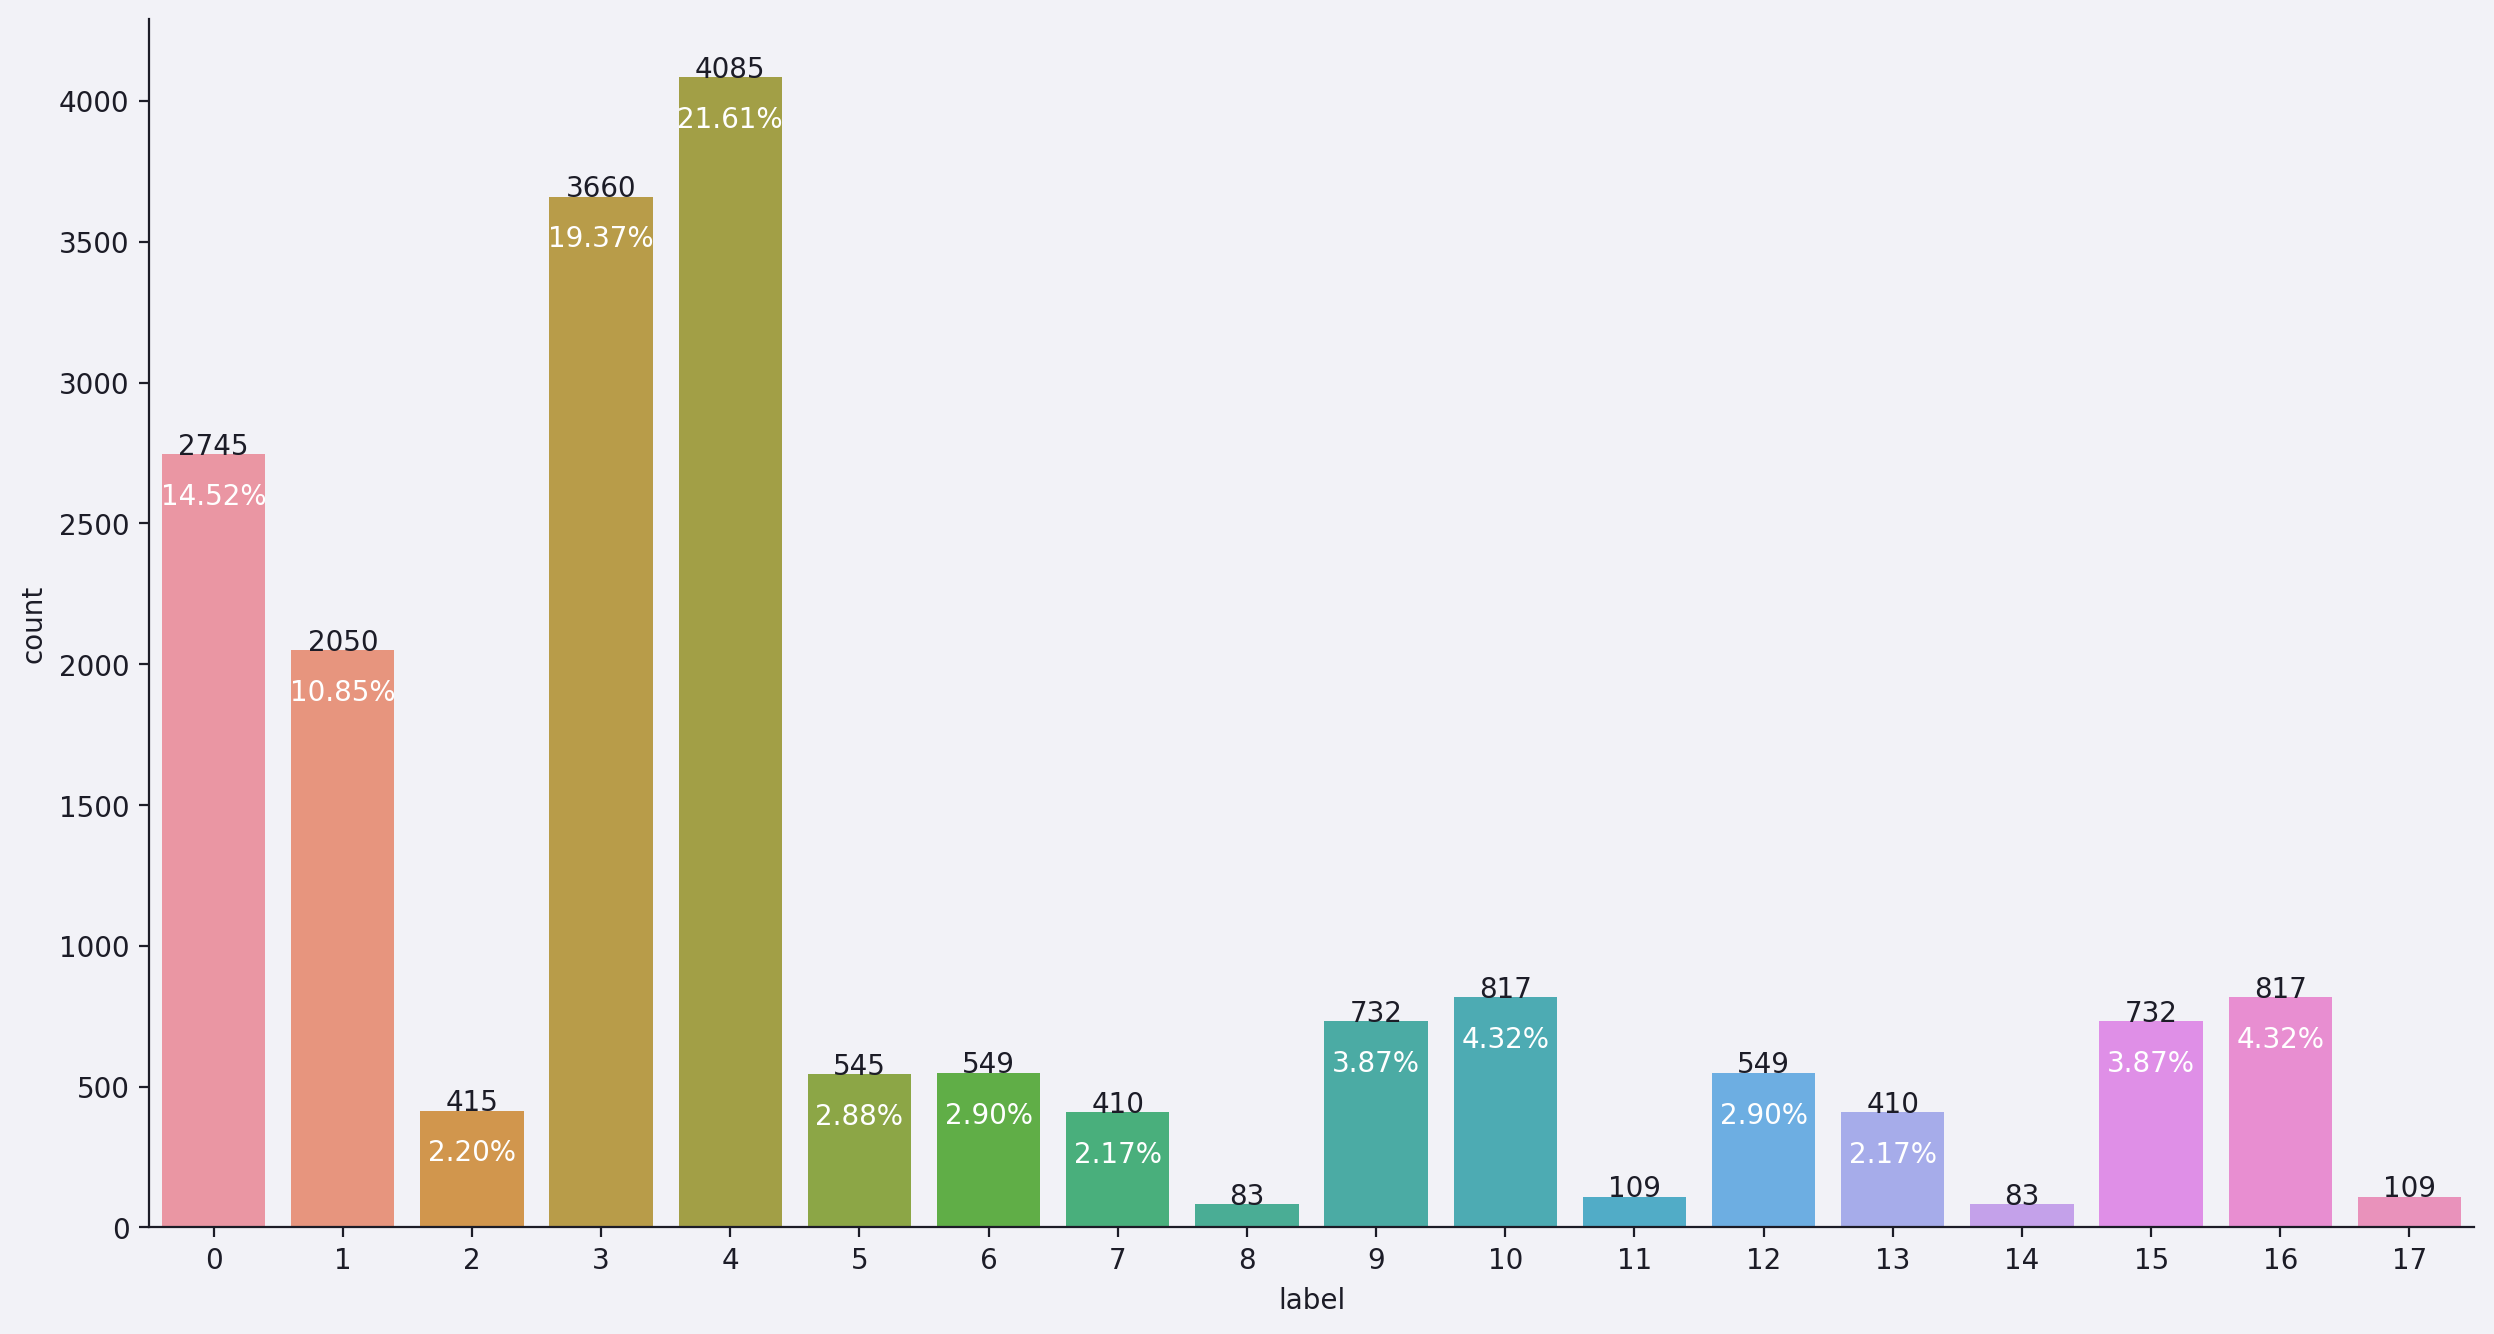

In [14]:
fig, ax = plt.subplots(1,1, figsize=(15,8))
ax = sns.countplot(x="label", data=train, ax=ax)
for patch in ax.patches:
    ax.annotate(f'{patch.get_height()}', xy=(patch.get_x() + patch.get_width() / 2, patch.get_height()), ha='center')
    if patch.get_height() > 200:
        ax.annotate(f'{patch.get_height() / len(train) * 100:.2f}%', xy=(patch.get_x() + patch.get_width() / 2, patch.get_height() - 100), color='white', va='top', ha='center')

#### 마스크를 제대로 착용한 상태에서 여성이면서 나이대가 60대 미만인 데이터의 비중이 가장 크네요.
#### 또한 전반적으로 고령층의 데이터가 상대적으로 적어보입니다.
#### 즉, 데이터가 상대적으로 많이 편향되어 있다는 걸 알 수 있네요.
<br/>

## 나이에 따른 데이터의 분포
#### 나이에 따라 데이터가 어떻게 분포하는지 알고 싶네요.

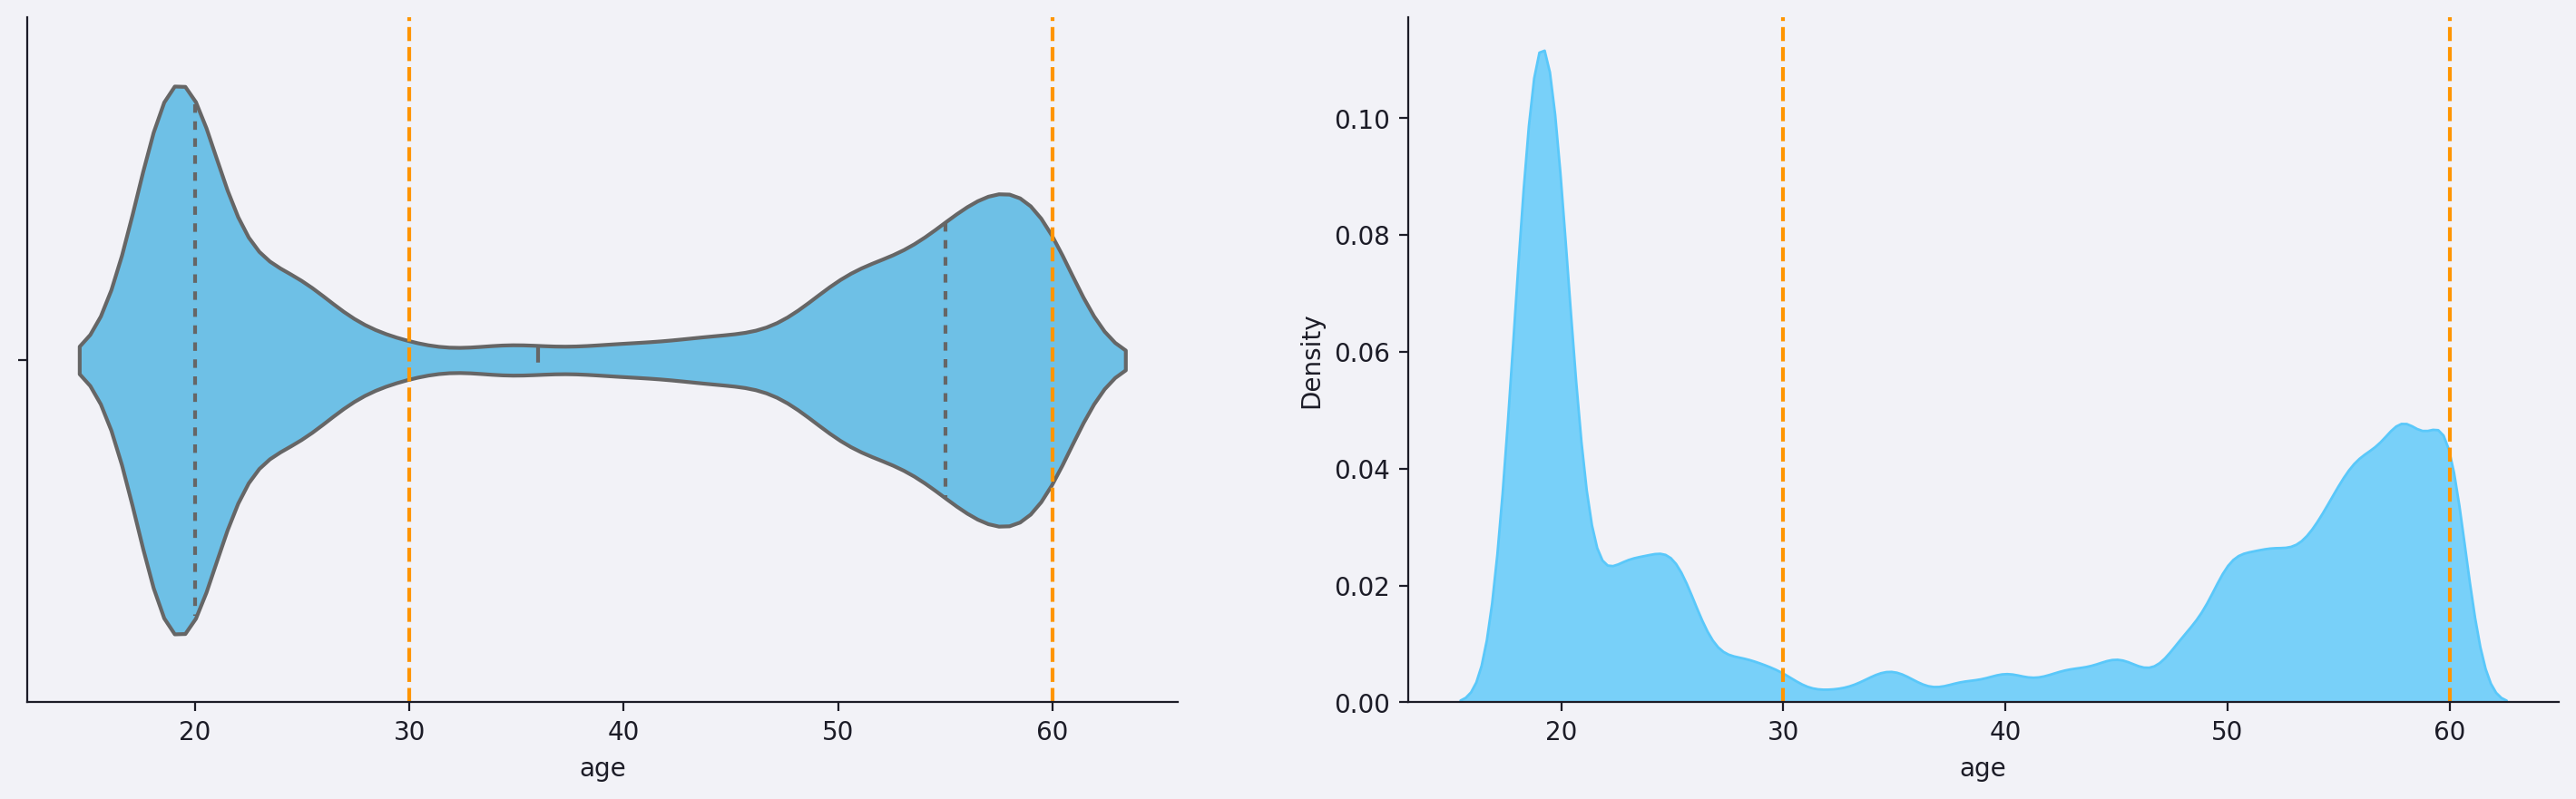

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))

plot1 = sns.violinplot(data=train, x='age', ax=axes[0], bw=0.1, inner='quartile', color=light_palette[-2])
plot2 = sns.kdeplot(data=train, x='age', fill=True, alpha=0.8, ax=axes[1], bw_method=0.05, color=light_palette[-2])

axes[0].axvline(30, c=light_palette[1], linestyle='--')
axes[0].axvline(60, c=light_palette[1], linestyle='--')

axes[1].axvline(30, c=light_palette[1], linestyle='--')
axes[1].axvline(60, c=light_palette[1], linestyle='--')

#### 위에서 살펴본 바와 같이 20대에 많은 데이터가 몰려있고, 60대 이상의 데이터는 현저히 적음을 알 수 있습니다.
#### 또한 중년층의 데이터도 밀도가 많이 낮아 보입니다.
<br/>

## 나이대 별 데이터 분포와 마스크 착용 상태
#### 앞에서 분류한 나이대 별로는 데이터가 어떻게 분포하는지, 나이대 별로 마스크 착용 상태의 특징이 유의미하게 드러나는지 보고 싶어요.

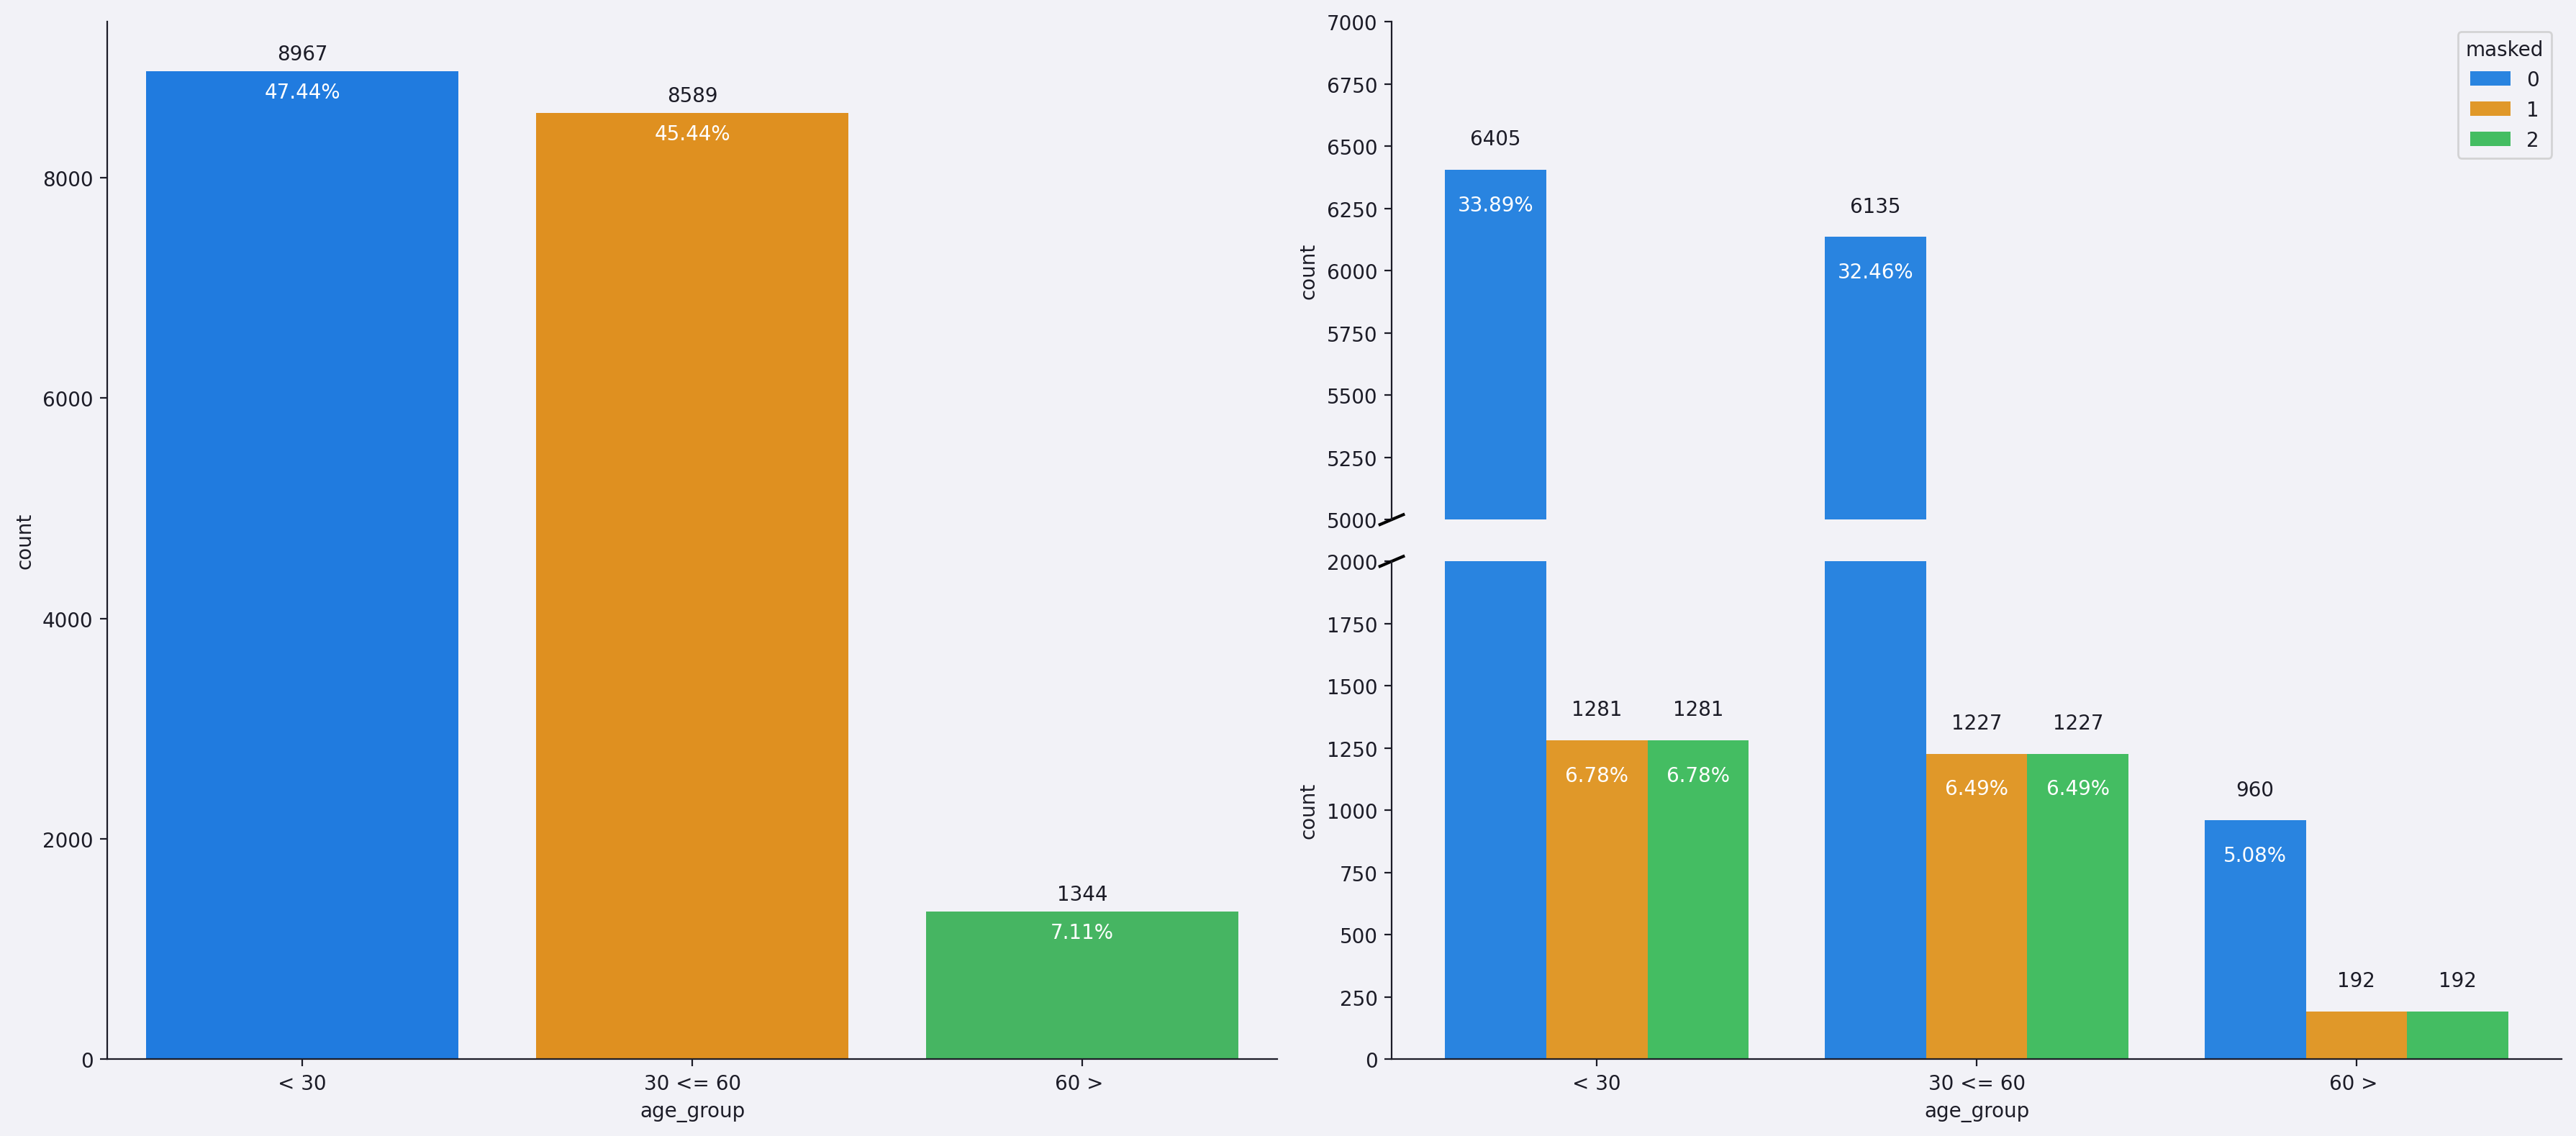

In [16]:
fig = plt.figure(figsize=(18,8))
axes = [None for _ in range(3)]

axes[0] = plt.subplot2grid((2,2), (0,0), rowspan=2)
axes[1] = plt.subplot2grid((2,2), (0,1), colspan=1)
axes[2] = plt.subplot2grid((2,2), (1,1), colspan=1)

sns.countplot(data=train, x='age_group', fill=True, ax=axes[0], palette=light_palette)
sns.countplot(data=train, x='age_group', fill=True, hue='masked', ax=axes[1])
sns.countplot(data=train, x='age_group', fill=True, hue='masked', ax=axes[2])

axes[0].set(xticklabels=['< 30', '30 <= 60', '60 > '])
axes[2].set(xticklabels=['< 30', '30 <= 60', '60 > '])

axes[1].set_ylim(5000, 7000)
axes[2].set_ylim(0, 2000)

sns.despine(ax=axes[2])
sns.despine(ax=axes[1], bottom=True)

axes[1].get_xaxis().set_visible(False)
axes[2].legend_.remove()

for ax in axes:
    for patch in ax.patches:
        ax.annotate(f'{patch.get_height()}', xy=(patch.get_x() + patch.get_width() / 2, patch.get_height() + 100), ha='center')
        if patch.get_height() > 200:
            ax.annotate(f'{patch.get_height() / len(train) * 100:.2f}%', xy=(patch.get_x() + patch.get_width() / 2, patch.get_height() - 100), color='white', va='top', ha='center')

d = .01
kwargs = dict(transform=axes[1].transAxes, color='k', clip_on=False)
axes[1].plot((-d, +d), (-d, +d), **kwargs)

kwargs.update(transform=axes[2].transAxes)
axes[2].plot((-d, +d), (1 - d, 1 + d), **kwargs)

fig.tight_layout()
plt.show()

#### 역시 60대 이하의 데이터가 많이 있음이 보이네요.
#### 그리고 상대적으로 모든 연령층에서 마스크를 제대로 착용한 상태가 가장 많은 비중을 차지함을 알 수 있습니다.
#### 하지만 이는 마스크를 제대로 착용한 데이터가 원래부터 많기 때문인 것으로 보입니다.
<br/>

## 마스크 착용 상태와 성별
#### 마스크 착용 상태의 데이터 분포를 알아보고, 성별 간의 상관관계가 유의미하게 드러나는지 확인해볼게요.

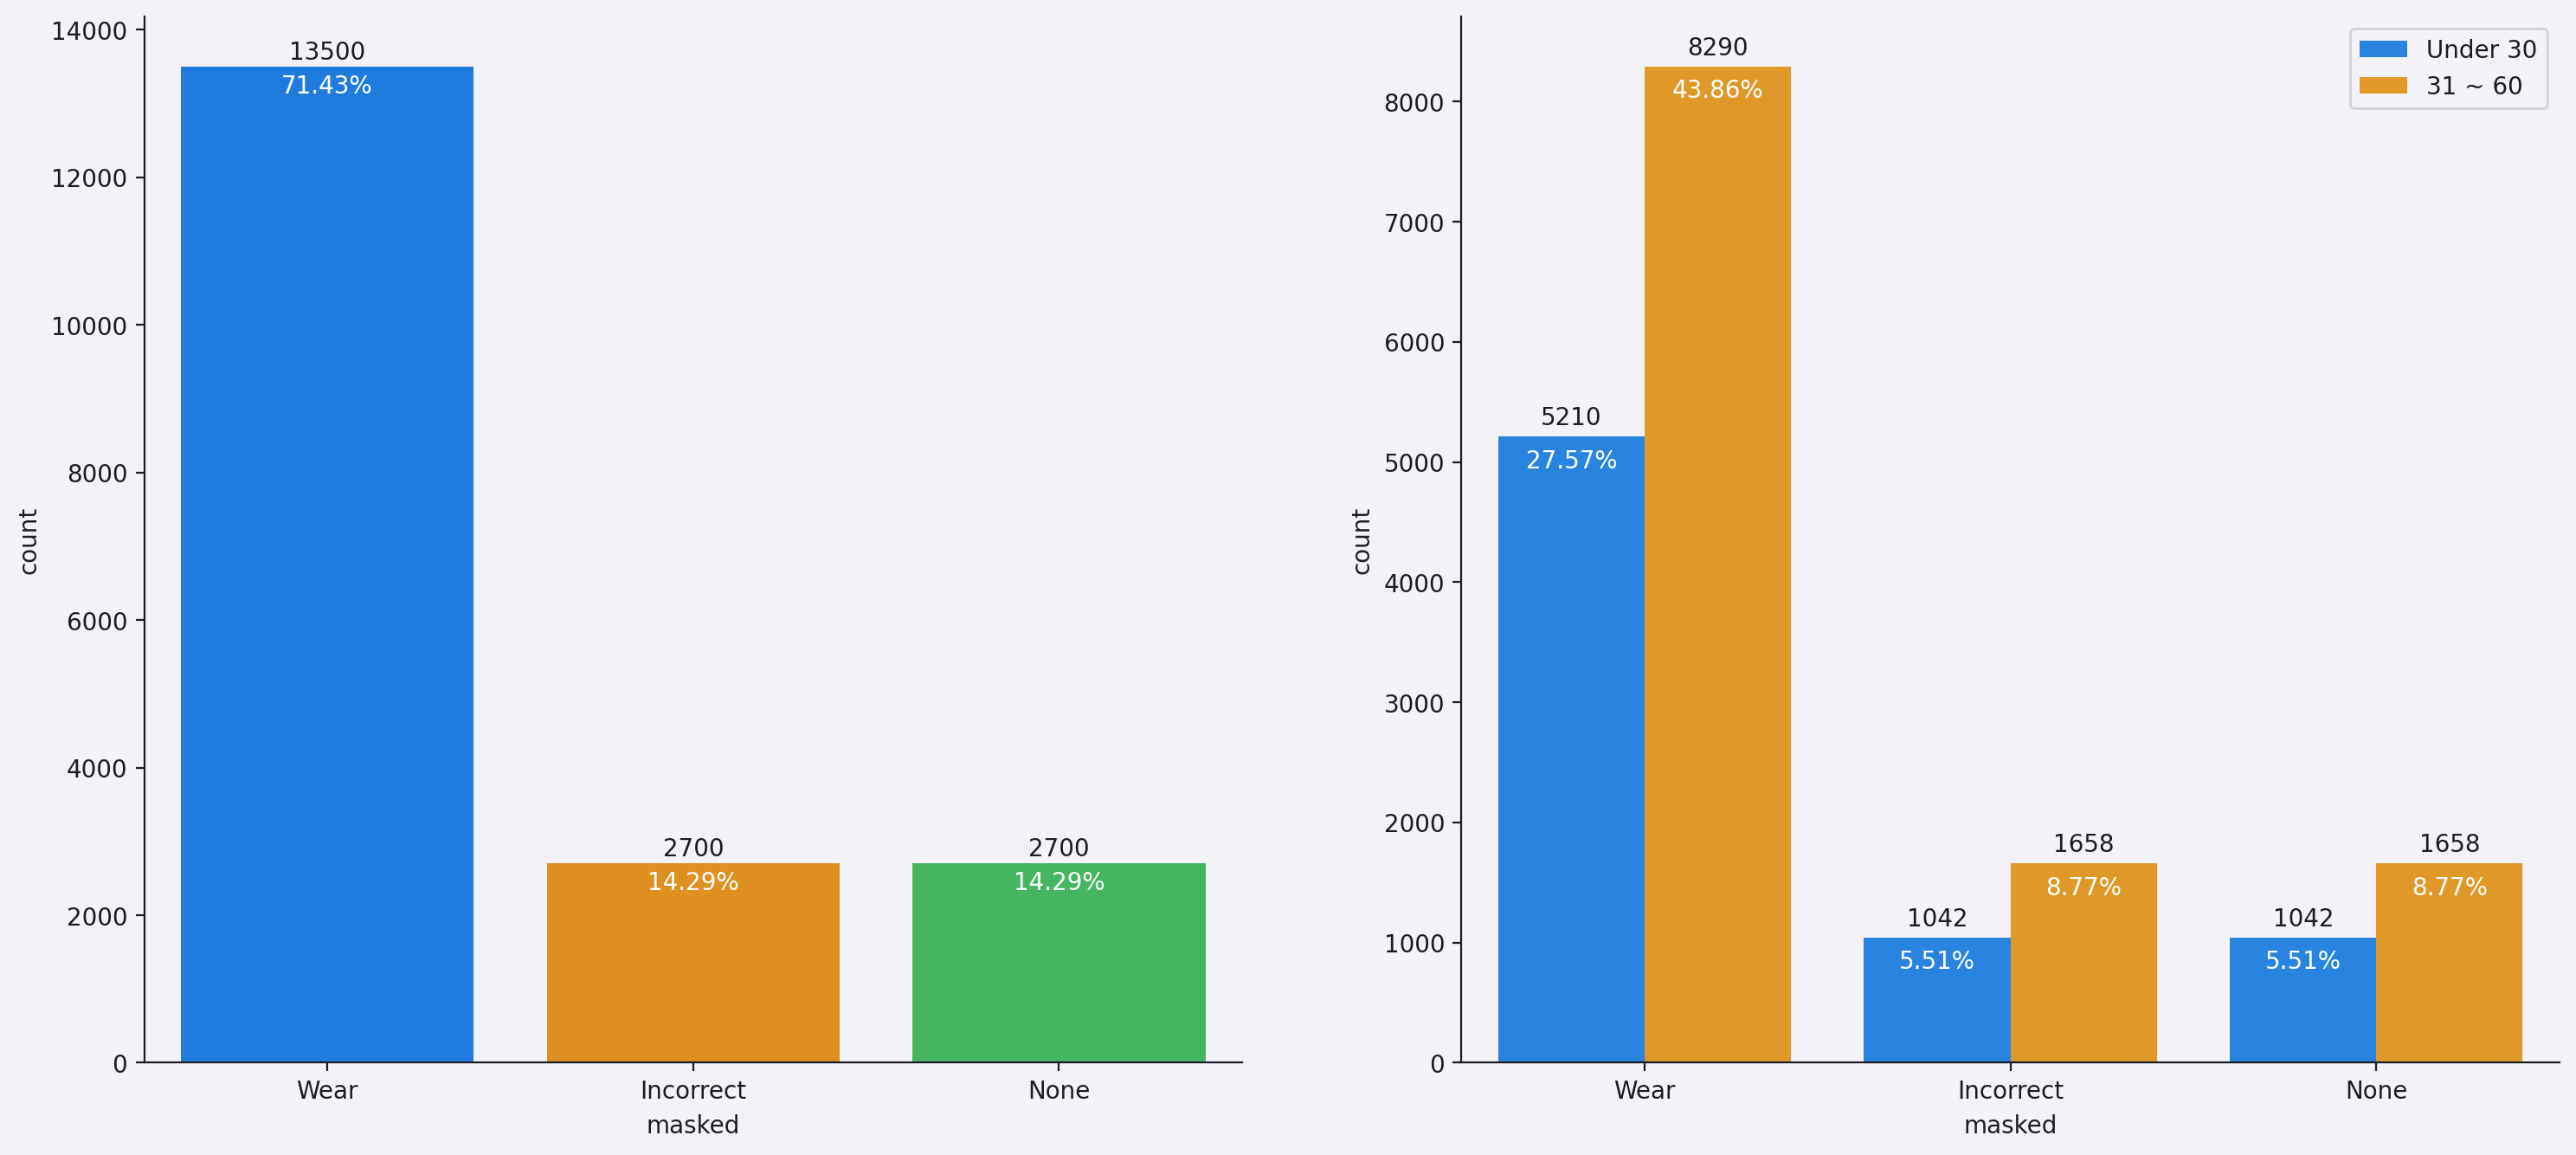

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(18,8))

plot1 =  sns.countplot(data=train, x='masked', ax=axes[0], palette=light_palette)
plot2 = sns.countplot(data=train, x='masked', hue='gender', ax=axes[1])

axes[0].set(xticklabels=['Wear', 'Incorrect', 'None'])
axes[1].set(xticklabels=['Wear', 'Incorrect', 'None'])

axes[1].legend(['Under 30', '31 ~ 60', 'Above 60'])

for ax in axes:
    for patch in ax.patches:
        ax.annotate(f'{patch.get_height()}', xy=(patch.get_x() + patch.get_width() / 2, patch.get_height() + 100), ha='center')
        if patch.get_height() > 200:
            ax.annotate(f'{patch.get_height() / len(train) * 100:.2f}%', xy=(patch.get_x() + patch.get_width() / 2, patch.get_height() - 100), color='white', va='top', ha='center')

#### 문제에서 제시된 바와 마찬가지로 마스크를 착용한 상태의 데이터가 가장 많음을 알 수 있어요.
#### 그리고 마스크 착용 상태가 어떻든 간에 여성 데이터의 비율이 높음을 알 수 있네요.
#### 하지만 이는 원래부터 여성의 데이터가 남성보다 많아서 상관관계를 보여줄 수는 없을 것 같아요.
<br/>

## 성별에 따른 데이터 분포
#### 성별에 따라 데이터가 어떻게 분포하는지 확인해볼게요.

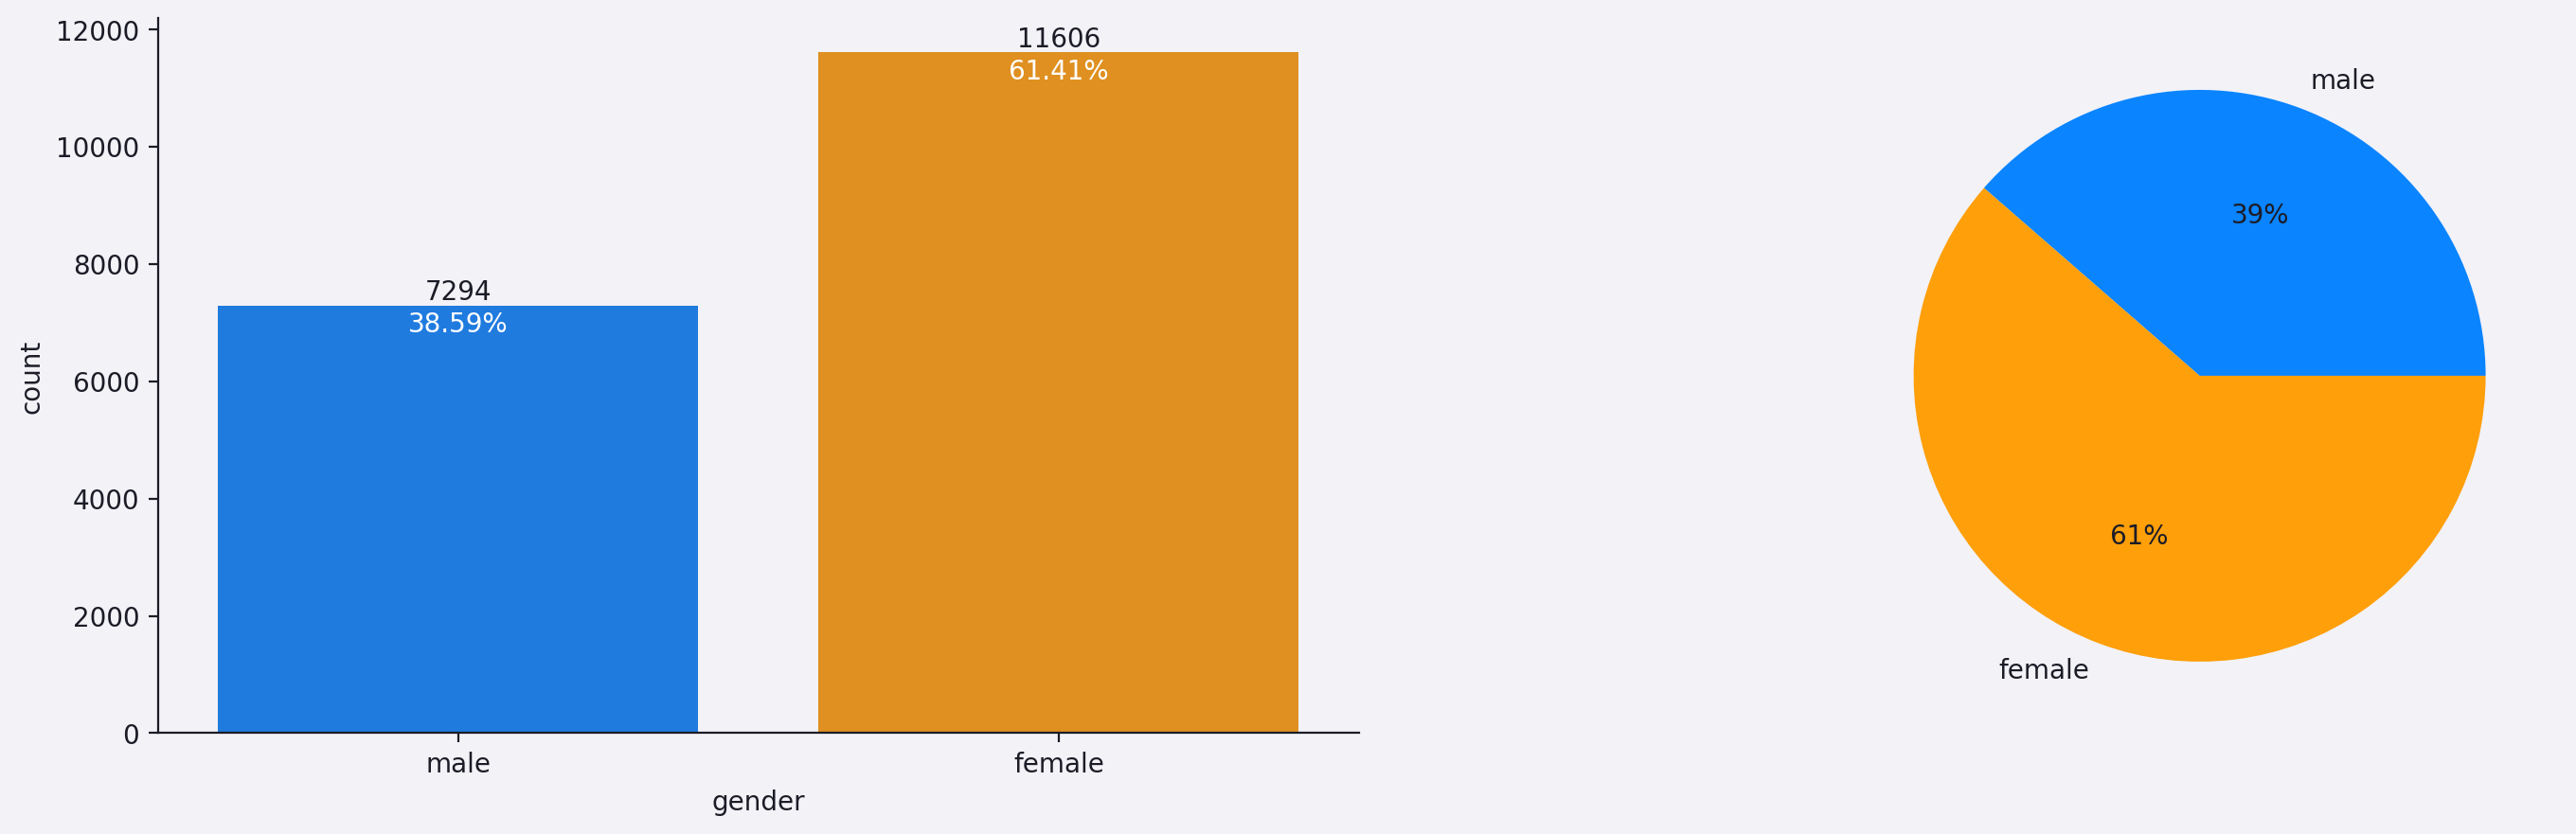

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))

gender_df = train.groupby(['gender'])['gender'].count()
axes[1].pie(gender_df.values,
                labels=['male', 'female'],
                autopct='%.0f%%',
               )

plot = sns.countplot(data=train, x='gender', ax=axes[0], palette=light_palette)

axes[0].set(xticklabels=['male', 'female'])

for patch in axes[0].patches:
    axes[0].annotate(f'{patch.get_height()}', xy=(patch.get_x() + patch.get_width() / 2, patch.get_height() + 100), ha='center')
    if patch.get_height() > 200:
        axes[0].annotate(f'{patch.get_height() / len(train) * 100:.2f}%', xy=(patch.get_x() + patch.get_width() / 2, patch.get_height() - 100), color='white', va='top', ha='center')

#### 여성이 남성보다 더 많은 비율을 차지하고 있음을 알 수 있어요.
<br/>

## 데이터 feature 간 상관관계 분석
#### 나이대, 성별, 마스크 착용 상태 사이에 과연 상관관계가 존재하는지, 존재한다면 그 정도는 어느 정도인지 알아보겠습니다.
#### 우선 필요 없는 컬럼은 제외하고 분석할게요.

In [19]:
train_valid = train.drop(columns=['id', 'age', 'directory', 'file', 'label'])
train_valid.head(10)

,gender,age_group,masked
0,1,1,0
1,1,1,2
2,1,1,0
3,1,1,0
4,1,1,0
5,1,1,1
6,1,1,0
7,1,1,0
8,1,1,0
9,1,1,0


<AxesSubplot:>

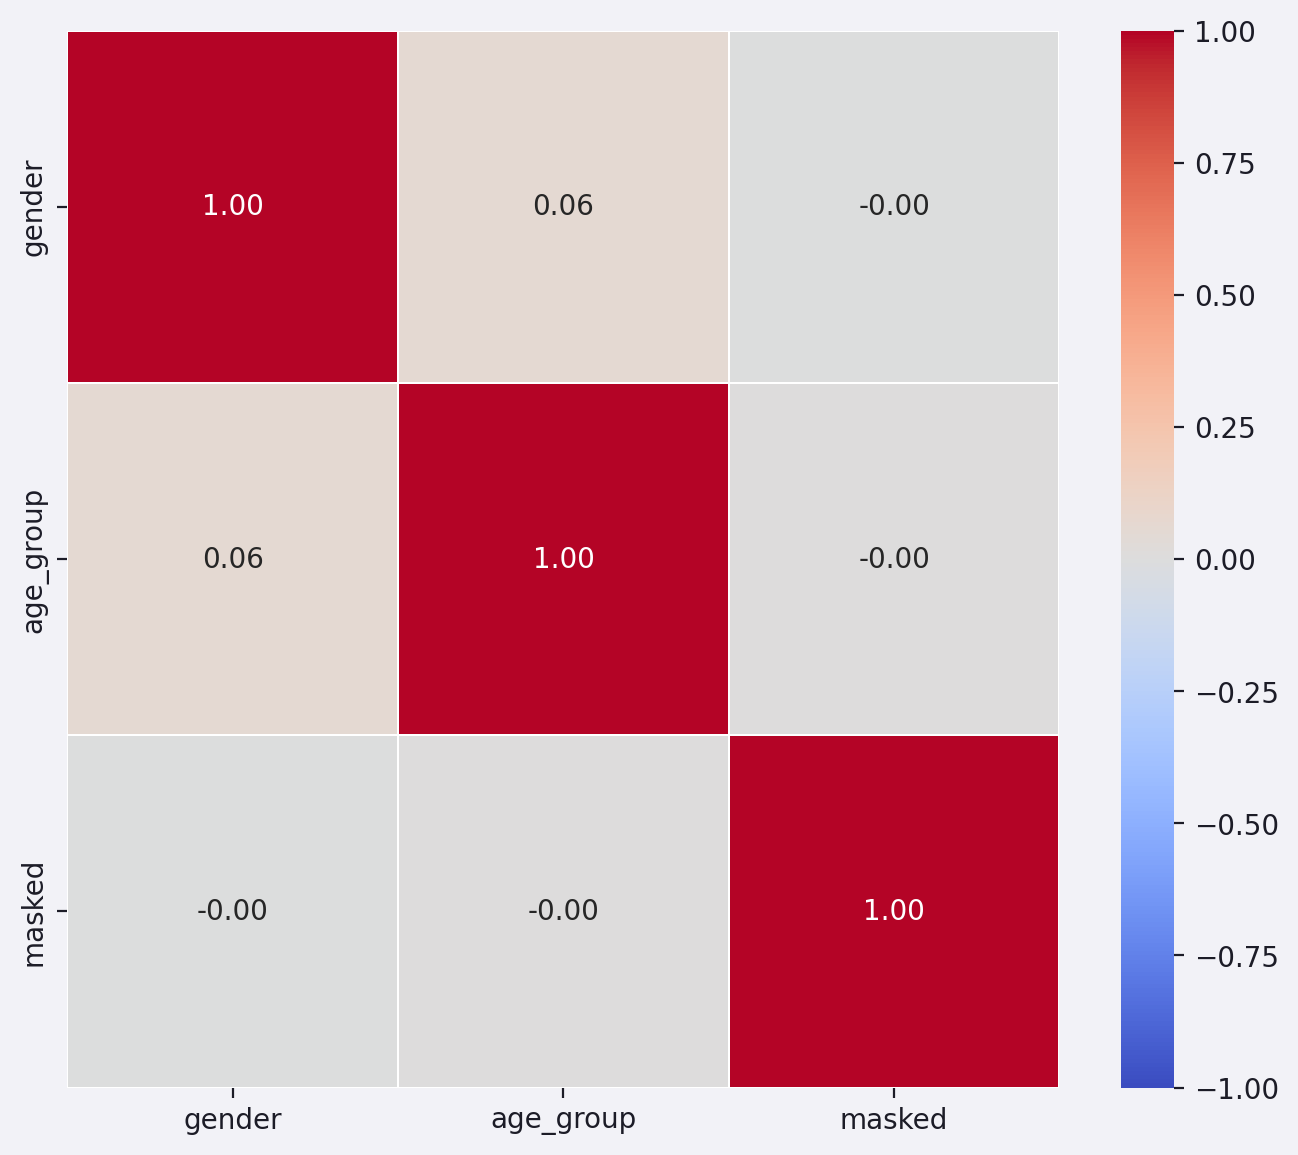

In [20]:
fig, ax = plt.subplots(1,1, figsize=(8, 7))

sns.heatmap(train_valid.corr(), ax=ax, vmin=-1, vmax=1, center=0, cmap='coolwarm', annot=True, fmt='.2f', linewidth=0.1)

#### Feature 간에는 상관관계가 없다고 봐도 될 것 같아요.
#### 나이대(age_group)와 성별(gender)의 상관관계가 0.06이긴 하지만,
#### 절댓값이 너무 작고 상식적으로 나이와 성별이 관계가 있다고 보기는 무리가 있어 보여요.
<br/>

## 이미지 데이터 분석
#### 이미지 데이터의 크기가 어떤지, 어떠한 데이터가 존재하는지를 대략적으로 알아보겠습니다.

In [21]:
image_size_df = pd.DataFrame(None, columns=['id', 'width', 'height'])

for i in range(len(train)):
    data = dict()
    
    data['id'] = train.loc[i, 'id']
    image_path = train.loc[i, 'directory'] + '/' + train.loc[i, 'file']
    image = Image.open(image_path)
    width, height = image.size
    
    data['width'] = int(width)
    data['height'] = int(height)
    
    image_size_df = image_size_df.append(data, ignore_index=True)
    
image_size_df.head(10)

,id,width,height
0,000001,384,512
1,000001,384,512
2,000001,384,512
3,000001,384,512
4,000001,384,512
5,000001,384,512
6,000001,384,512
7,000002,384,512
8,000002,384,512
9,000002,384,512


#### 이미지의 크기는 모두 384 * 512의 크기를 지니고 있음을 알 수 있어요.

In [22]:
image_size_df[['width', 'height']].describe()

,width,height
count,18900,18900
unique,1,1
top,384,512
freq,18900,18900


#### 랜덤으로 각 레이블 별 데이터를 뽑아서 대략적으로 어떠한 이미지가 있는지 알아볼게요.

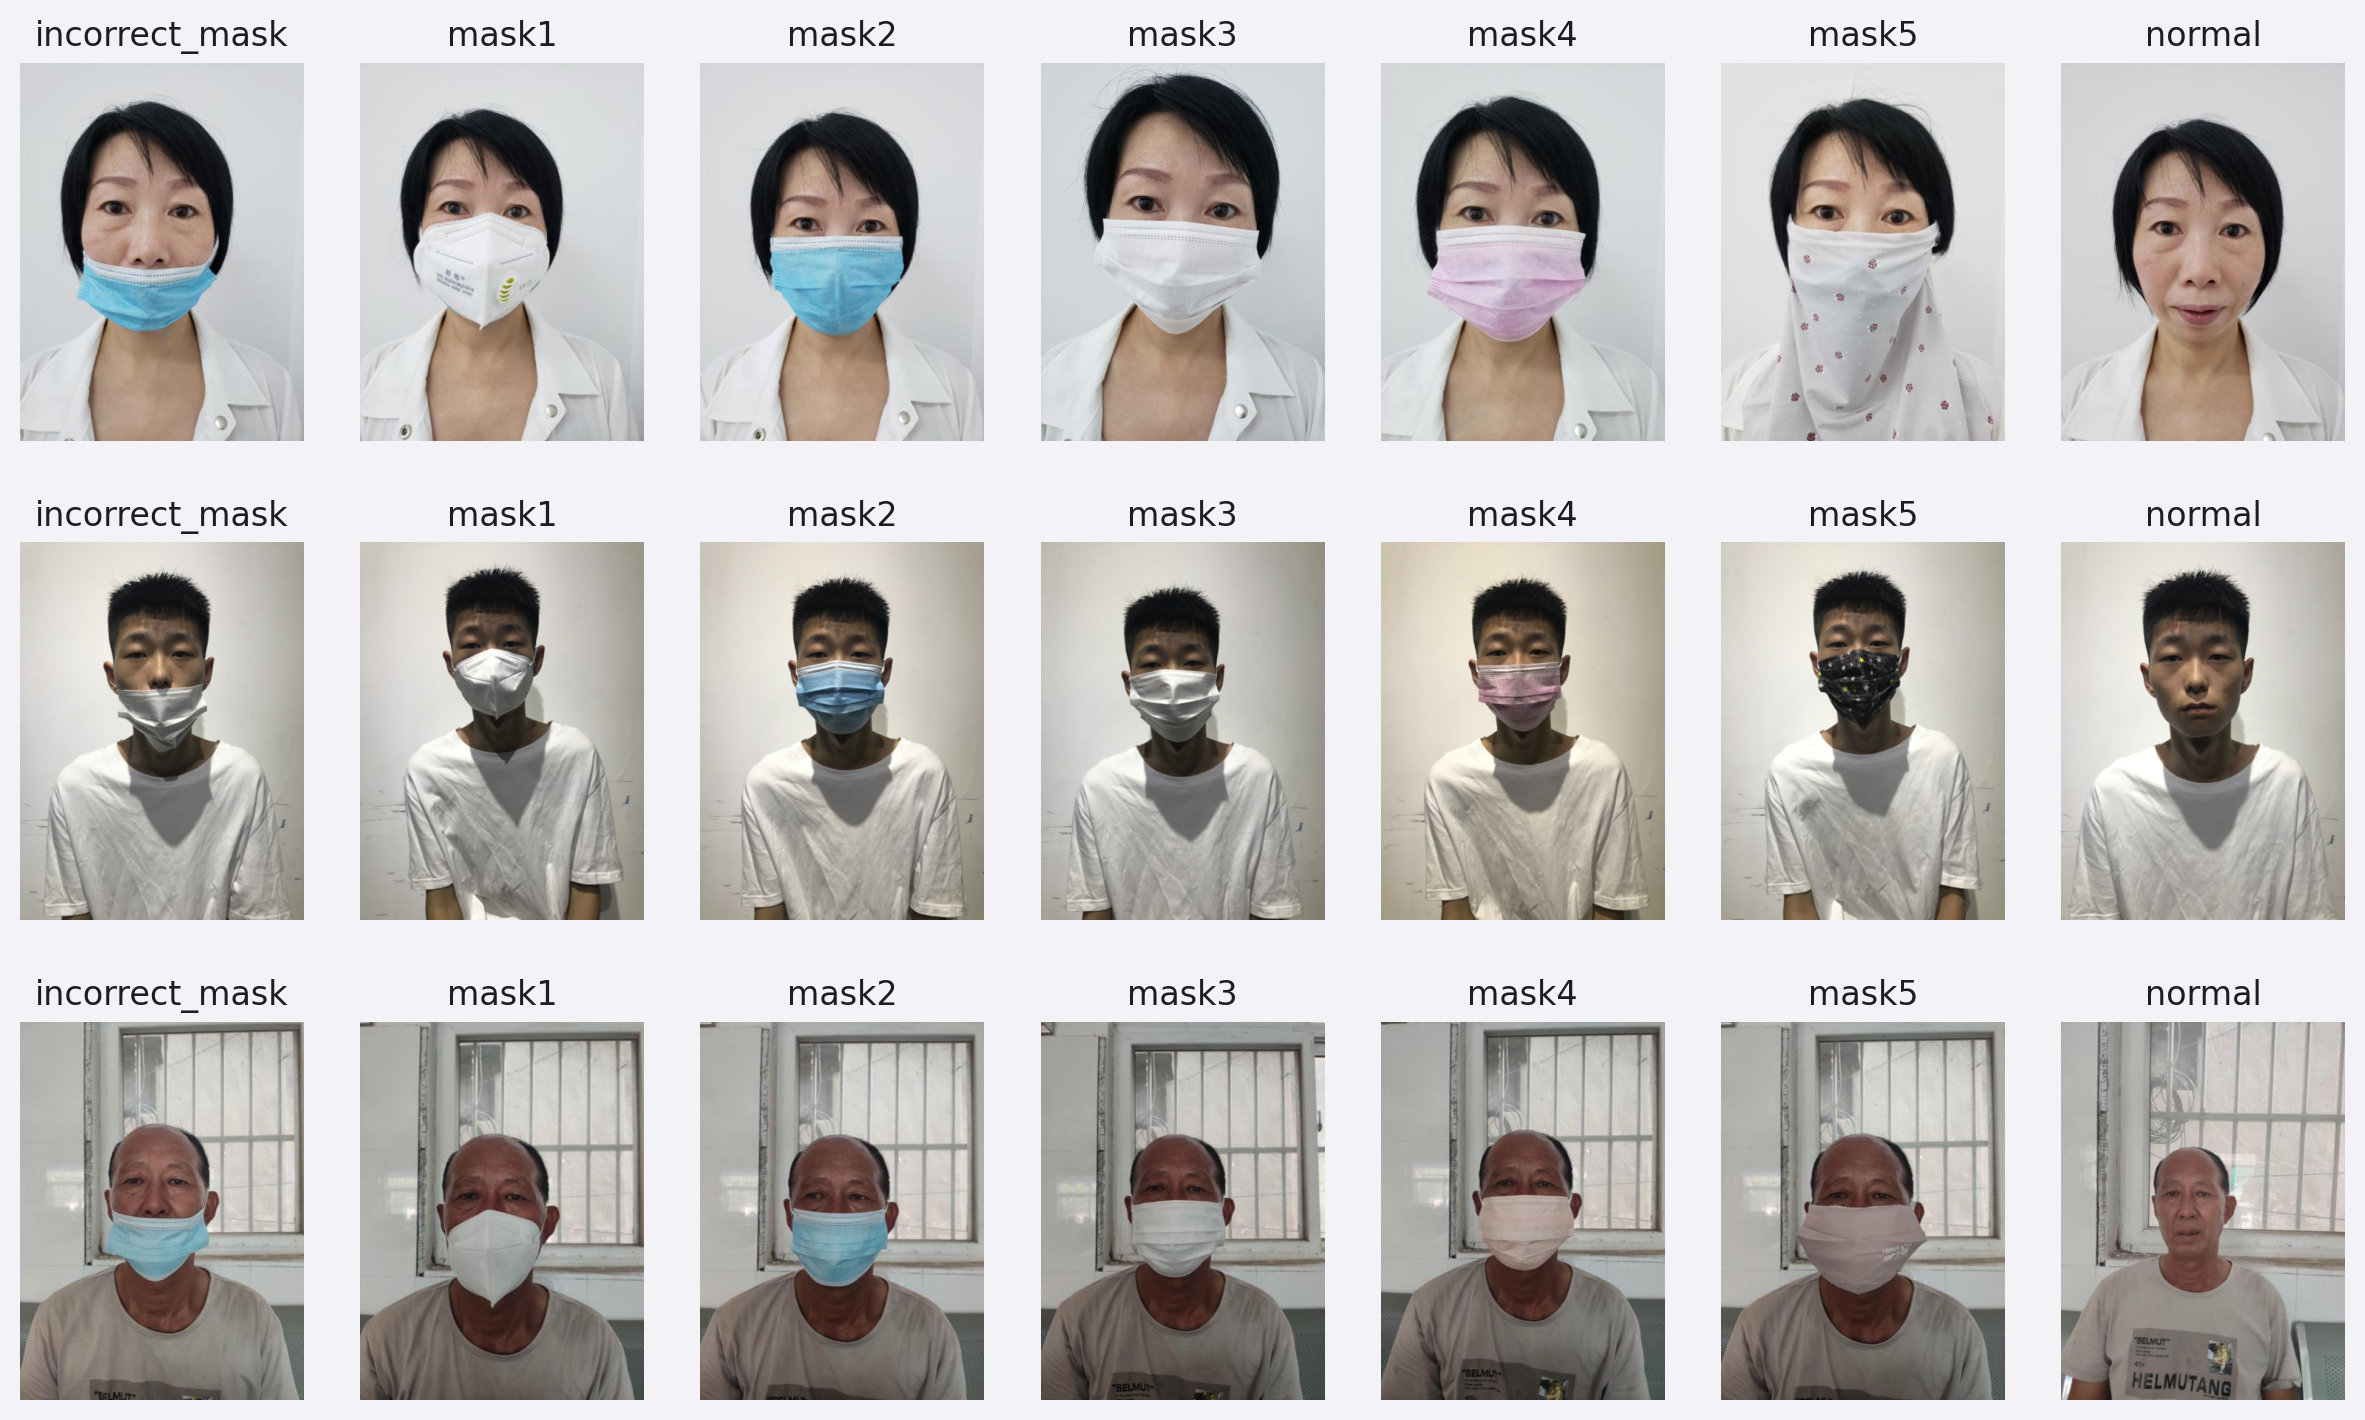

In [23]:
num = 3
fig, axes = plt.subplots(num, 7, figsize=(15, num * 3))

path_list = train['directory'].unique()
index = np.random.choice(len(path_list), num)
directory_list = path_list[index]

for i in range(num):
    candidate = train.loc[train['directory'] == directory_list[i]]
    candidate = candidate.sort_values(by='file', ascending=True)
    
    for j in range(len(candidate)):
        image_directory = candidate['directory'].iloc[j]
        image_file = candidate['file'].iloc[j]
        image_path = candidate['directory'].iloc[j] + '/' + candidate['file'].iloc[j]
        image = plt.imread(image_path)
        
        
        image_file = image_file.split('.')[0]
        
        axes[i][j].set_title(f'{image_file}')
        axes[i][j].imshow(image)
        axes[i][j].axis('off')

#### 랜덤으로 이미지를 추출하여 출력하는 걸 알 수 있습니다.
<br/>

## 결론

#### 분류 모델의 성능을 높이려면 아래 문제를 해결해야 할 것으로 보입니다.

1. 데이터의 불균형
   - 나이대, 성별, 마스크 착용 상태 관점에서 모두 데이터가 한쪽으로 편향되어 있습니다.
   - 이를 해결하려면 over sampling이 요구되는데, 그러면 데이터를 어떻게 확보할 수 있을까요?
   - Data Augmentation으로 마스크를 제대로 착용하지 않거나 미착용한 상태의 이미지를 늘리는 방법이 있어 보입니다.
2. 데이터 부족
    - 학습 데이터가 약 1만 개인데 반해, 18개의 레이블로 데이터를 분류해야 하는 건 쉽지 않아 보입니다.
    - 마찬가지로 Data Augmentation으로 이를 보완할 수 있을 것 같습니다.
3. 모델 제작 방법
    - 18개의 레이블로 데이터를 분류하는 모델 한 개를 만들어야 할까요?
    - 아니면 나이대, 성별, 마스크 착용 상태를 각각 분류하는 모델 세 개를 따로 만들어야 할까요?